In [1]:
import pandas as pd
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
import numpy as np
from utils import peek
import config
import missingno as msno
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.decomposition import PCA
import pickle

In [2]:
data = pd.read_csv(config.DATA)

<AxesSubplot:>

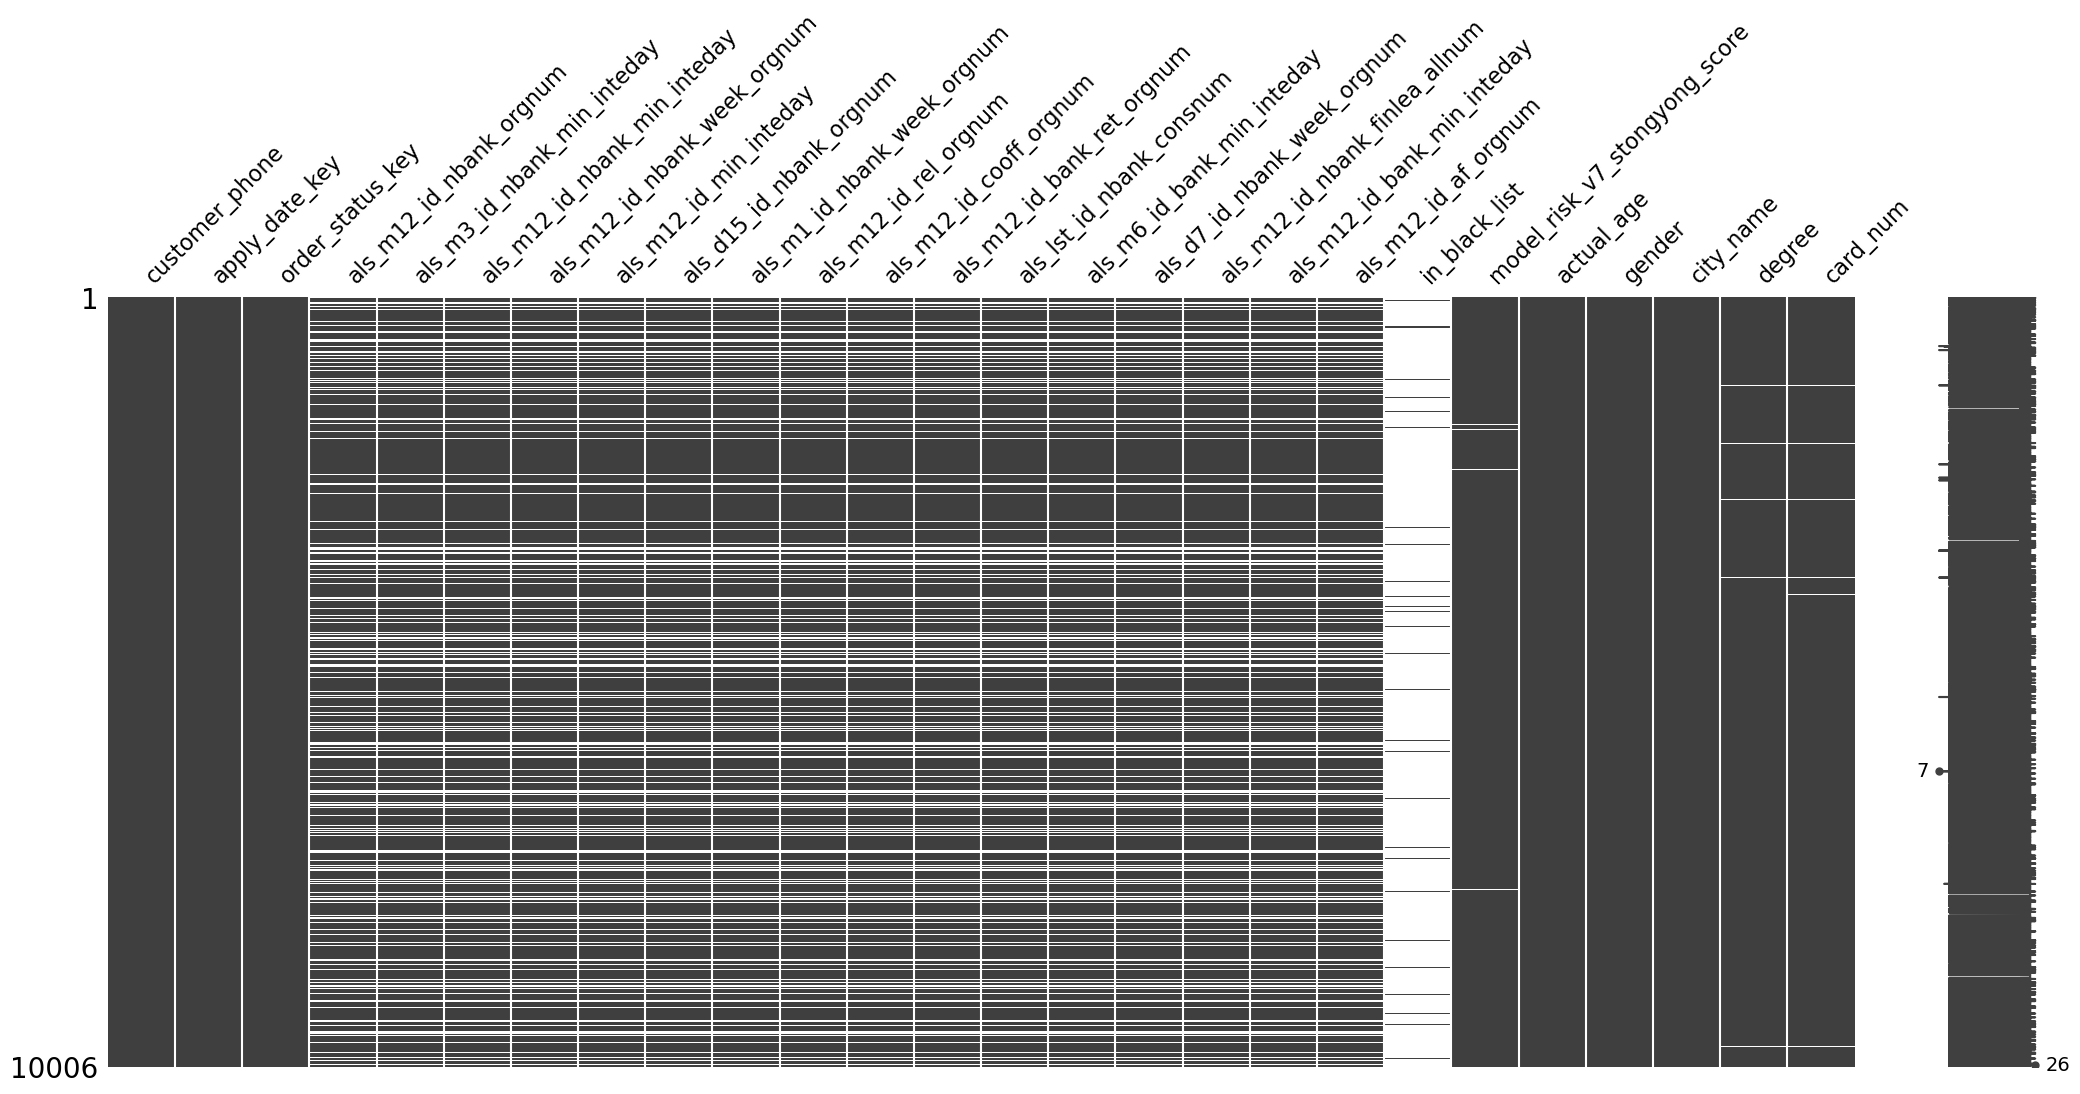

In [3]:
msno.matrix(data)

<AxesSubplot:>

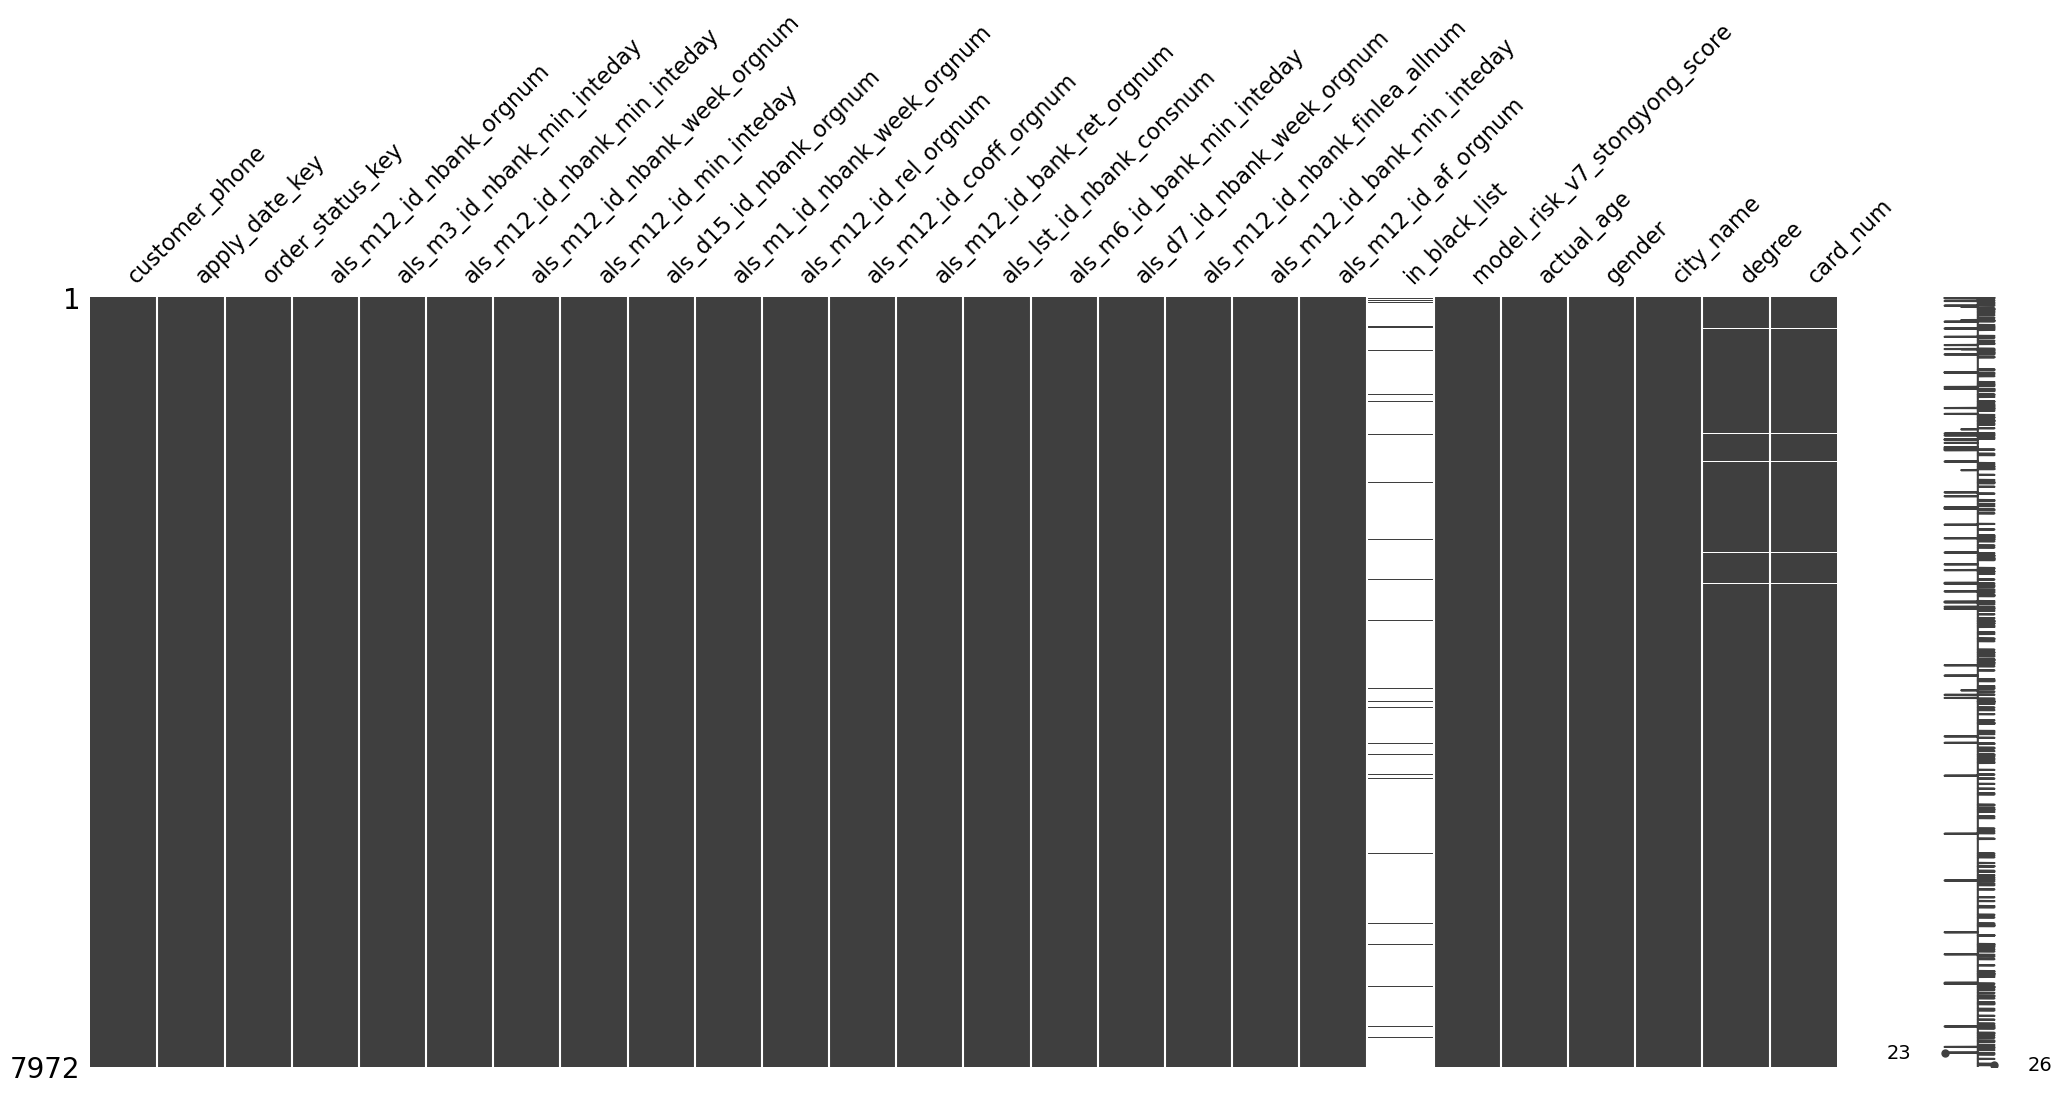

In [4]:
subset = ['als_m12_id_nbank_orgnum', 'model_risk_v7_stongyong_score']
# subset = ['als_m12_id_nbank_orgnum', 'model_risk_v7_stongyong_score', 'v6_seq_online']
msno.matrix(data.dropna(subset=subset))

根据多头（'als_m12_id_nbank_orgnum'）为空筛掉2000多个用户，这些用户的核卡率接近38%，属于优质客群，暂时不对这个客群建模。另外根据腾讯反欺诈，尚为综合信用评估去掉30多个空值的用户

In [5]:
data = data.dropna(subset=subset)

In [6]:
duplicates = data[data.duplicated(['customer_phone', 'apply_date_key'])].sort_values(['customer_phone'])['customer_phone'].tolist()
remove_duplicates = data[data['customer_phone'].isin(duplicates)].query('order_status_key != 6')
data = data[~data['customer_phone'].isin(duplicates)]
data = pd.concat([data, remove_duplicates])

根据之前的第三方数据的分析结果，百融近12个月非银机构的申请机构数能够有效划分客群，当设置阈值为8时，能够去除20%的被拒客户，同时召回率在99% (见/sda/share/notebooks/huweipeng/长安银行第三方数据检验.ipynb), 同时黑名单(in_black_list)也可以在接近不牺牲核卡用户的情况下，去掉大约3.5%的被拒用户。 因此先使用这两个特征做硬过滤后，再对剩下的特征做进一步探索

In [7]:
total_records = data.shape[0]
print(f'data has {data.shape[0]} records')
data = data.query('als_m12_id_nbank_orgnum <= 8')
records_left = data.shape[0]
print(f'{total_records - records_left} records are dropped')
data = data.query('in_black_list != True')
records_left2 = data.shape[0]
print(f'{records_left - records_left2} records are dropped')
print(f'data has {data.shape[0]} records remained')

data has 7941 records
1523 records are dropped
201 records are dropped
data has 6217 records remained


In [8]:
data = data.drop(columns='in_black_list')

In [9]:
data['order_status_key'] = data['order_status_key'].map({2:1}).fillna(0)
data['order_status_key'].value_counts()

0.0    4178
1.0    2039
Name: order_status_key, dtype: int64

In [10]:
print(*data.columns, sep=", ")

customer_phone, apply_date_key, order_status_key, als_m12_id_nbank_orgnum, als_m3_id_nbank_min_inteday, als_m12_id_nbank_min_inteday, als_m12_id_nbank_week_orgnum, als_m12_id_min_inteday, als_d15_id_nbank_orgnum, als_m1_id_nbank_week_orgnum, als_m12_id_rel_orgnum, als_m12_id_cooff_orgnum, als_m12_id_bank_ret_orgnum, als_lst_id_nbank_consnum, als_m6_id_bank_min_inteday, als_d7_id_nbank_week_orgnum, als_m12_id_nbank_finlea_allnum, als_m12_id_bank_min_inteday, als_m12_id_af_orgnum, model_risk_v7_stongyong_score, actual_age, gender, city_name, degree, card_num


In [11]:
def calc_iv(matrix, feature, target, pr=False):
    df = matrix.copy()
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])

    data['Distribution Good'] = (data['Good'] + 1) / data['Good'].sum()
    data['Distribution Bad'] = (data['Bad'] + 1) / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    data['IV'] = (data['Distribution Good'] - data['Distribution Bad']) * data['WoE']

    if pr:
        print(data.sort_values('Value'))
        print('IV = ', round(data['IV'].sum(), 6))

    return round(data['IV'].sum(), 6)

In [12]:
def binning(series):
    percentiles = list(range(0, 101, 10))
    val = np.percentile(series, percentiles).tolist()
    if min(series) >= 0:
        bins = list(sorted(set([min(val) - 1] + val)))
    else:
        bins = list(sorted(set([-10000, -9999] + [min(val) - 1] + val)))
        
    series_bin = pd.cut(series, bins, labels=list(range(len(bins) - 1))).astype("int")
    return series_bin
    
data_bin = data.copy()
data_bin.loc[:, 'als_m12_id_nbank_orgnum':'als_m12_id_af_orgnum'] = data_bin.loc[:, 'als_m12_id_nbank_orgnum':'als_m12_id_af_orgnum'].apply(binning)

data_bin['model_risk_v7_stongyong_score'] = \
    MinMaxScaler().fit_transform(data_bin[['model_risk_v7_stongyong_score']])
data_bin['model_risk_v7_stongyong_score'] = \
    data_bin[['model_risk_v7_stongyong_score']].apply(binning)

feature_iv = []
for f in data_bin.iloc[:, 3:].columns:
    feature_iv.append([f, calc_iv(data_bin, f, 'order_status_key', False)])
feature_iv = pd.DataFrame(feature_iv, columns=['feature', 'iv']).sort_values('iv', ascending=False)

X = add_constant(data_bin.loc[:, 'als_m12_id_nbank_orgnum':'model_risk_v7_stongyong_score'])
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns).rename('vif')

feature_iv = feature_iv.merge(vif, left_on='feature', right_index=True)

In [13]:
feature_iv.reset_index(drop=True)

,feature,iv,vif
0,model_risk_v7_stongyong_score,0.561341,1.138166
1,als_m12_id_nbank_orgnum,0.426821,4.370553
2,als_m12_id_nbank_min_inteday,0.416843,7.110701
3,als_m12_id_min_inteday,0.369171,4.823683
4,als_m3_id_nbank_min_inteday,0.356881,2.309763
5,als_lst_id_nbank_consnum,0.149209,3.223594
6,als_d15_id_nbank_orgnum,0.136639,2.494492
7,als_m1_id_nbank_week_orgnum,0.099983,1.689658
8,als_m12_id_rel_orgnum,0.096683,1.917656
9,als_m6_id_bank_min_inteday,0.089838,2.330355


In [14]:
age = data_bin[['customer_phone', 'actual_age']].dropna(subset=['actual_age'])
age['actual_age'] = age[['actual_age']].apply(binning)

In [15]:
data_bin.drop('actual_age', axis=1, inplace=True)
data_bin = data_bin.merge(age, on='customer_phone', how='left')
data_bin['actual_age'] = data_bin['actual_age'].fillna(-1)
data_bin['actual_age'].value_counts()

2     754
4     693
1     684
7     640
8     618
9     606
5     606
6     582
10    566
3     561
0      11
Name: actual_age, dtype: int64

In [16]:
calc_iv(data_bin, 'actual_age', 'order_status_key', True)

      Variable  Value  All  Good  Bad  Distribution Good  Distribution Bad  \
8   actual_age      0   11     0   11           0.000490          0.002804   
9   actual_age      1  684   116  568           0.057297          0.132975   
6   actual_age      2  754   223  531           0.109696          0.124328   
7   actual_age      3  561   165  396           0.081293          0.092779   
5   actual_age      4  693   258  435           0.126836          0.101893   
4   actual_age      5  606   193  413           0.095005          0.096752   
3   actual_age      6  582   217  365           0.106758          0.085534   
0   actual_age      7  640   245  395           0.120470          0.092545   
10  actual_age      8  618   229  389           0.112635          0.091143   
2   actual_age      9  606   217  389           0.106758          0.091143   
1   actual_age     10  566   179  387           0.088149          0.090675   

         WoE        IV  
8  -1.745117  0.004039  
9  -0.841917 

0.095757

In [17]:
data_bin['gender'] = data_bin['gender'].fillna("u")
calc_iv(data_bin, 'gender', 'order_status_key', True)

  Variable   Value   All  Good   Bad  Distribution Good  Distribution Bad  \
0   gender  female  2248   941  1307           0.461312          0.305679   
1   gender    male  4073  1101  2972           0.539667          0.694789   

        WoE        IV  
0  0.411540  0.064049  
1 -0.252655  0.039192  
IV =  0.103242


0.103242

In [18]:
major_city = ['u', '西安市', '宝鸡市', '咸阳市', '渭南市', '延安市',' 铜川市', '天水市']
data_bin.loc[data_bin['city_name'].isin(major_city), 'city_name2'] = data_bin['city_name']
data_bin['city_name2'] = data_bin['city_name2'].fillna('rare')

In [19]:
data_bin['city_name2'].value_counts()

u       1786
西安市     1141
rare     978
宝鸡市      840
咸阳市      673
渭南市      520
延安市      314
天水市       69
Name: city_name2, dtype: int64

In [20]:
calc_iv(data_bin, 'city_name2', 'order_status_key', True)

     Variable Value   All  Good   Bad  Distribution Good  Distribution Bad  \
2  city_name2  rare   978   302   676           0.148384          0.158215   
3  city_name2     u  1786   560  1226           0.274731          0.286749   
7  city_name2   咸阳市   673   190   483           0.093536          0.113111   
5  city_name2   天水市    69    13    56           0.006856          0.013321   
4  city_name2   宝鸡市   840   332   508           0.163075          0.118953   
1  city_name2   延安市   314    95   219           0.047013          0.051414   
6  city_name2   渭南市   520   179   341           0.088149          0.079925   
0  city_name2   西安市  1141   371   770           0.182174          0.180182   

        WoE        IV  
2 -0.064149  0.000631  
3 -0.042817  0.000515  
7 -0.190022  0.003720  
5 -0.664204  0.004294  
4  0.315484  0.013920  
1 -0.089490  0.000394  
6  0.097936  0.000805  
0  0.010995  0.000022  
IV =  0.0243


0.0243

In [21]:
data['degree'] = data['degree'].fillna("NONE")
calc_iv(data, 'degree', 'order_status_key', True)

  Variable     Value   All  Good   Bad  Distribution Good  Distribution Bad  \
3   degree      NONE    47     2    45           0.001471          0.011010   
1   degree      大学专科  4330  1419  2911           0.696420          0.696984   
0   degree      大学本科   806   360   446           0.177048          0.106989   
4   degree  硕士（含）及以上    43    19    24           0.009809          0.005984   
2   degree     高中及以下   991   239   752           0.117705          0.180230   

        WoE            IV  
3 -2.012656  1.919821e-02  
1 -0.000810  4.572046e-07  
0  0.503693  3.528798e-02  
4  0.494230  1.890431e-03  
2 -0.426053  2.663898e-02  
IV =  0.083016


0.083016

In [22]:
data['card_num'] = data['card_num'].fillna('NONE')
calc_iv(data.query('card_num != "NONE"'), 'card_num', 'order_status_key', True)

   Variable  Value   All  Good   Bad  Distribution Good  Distribution Bad  \
1  card_num     1张  1774   588  1186           0.289151          0.287340   
3  card_num     2张  1539   623   916           0.306333          0.221980   
0  card_num     3张   860   312   548           0.153657          0.132898   
2  card_num  4张及以上   804   282   522           0.138930          0.126604   
4  card_num   无信用卡  1191   232   959           0.114384          0.232389   

        WoE        IV  
1  0.006283  0.000011  
3  0.322084  0.027169  
0  0.145146  0.003013  
2  0.092907  0.001145  
4 -0.708853  0.083649  
IV =  0.114987


0.114987

In [23]:
data.query('degree == "NONE" | card_num == "NONE"').shape

(49, 25)

card_num和学历为NONE是因为问卷下线导致的，在生产环境中也可能出现这种情况。模型要兼容这种情况发生

In [24]:
use_features = feature_iv.query('iv > 0.02')['feature'].tolist() + ['in_black_list', 'actual_age', 'gender', 'degree', 'card_num']
pickle.dump(use_features, open(config.USE_FEATURES, "wb"))

## 总结
### 初步使用以下特征
'model_risk_v7_stongyong_score',
'als_m12_id_nbank_orgnum',  
'als_m12_id_nbank_min_inteday',  
'als_m12_id_min_inteday',  
'als_m3_id_nbank_min_inteday',
'als_m12_id_nbank_week_orgnum',  
'als_lst_id_nbank_consnum',  
'als_d15_id_nbank_orgnum',  
'als_m1_id_nbank_week_orgnum',  
'in_black_list',  
'actual_age',  
'gender',  
'degree',  
'card_num'  

### 预处理方式
- 去除重复记录
- order_status_key映射为0和1
- 去除als_m12_id_nbank_orgnum > 8 或者在百融黑名单中的客户
- 去除als_m12_id_nbank_orgnum, model_risk_v7_stongyong_score, v6_seq_online, omriskscoregeneral为空的客户
- gender为空的NONE来处理
- age为空的用-1来填充

below you can do what the fuck you want

In [25]:
data.describe()

,order_status_key,als_m12_id_nbank_orgnum,als_m3_id_nbank_min_inteday,als_m12_id_nbank_min_inteday,als_m12_id_nbank_week_orgnum,als_m12_id_min_inteday,als_d15_id_nbank_orgnum,als_m1_id_nbank_week_orgnum,als_m12_id_rel_orgnum,als_m12_id_cooff_orgnum,als_m12_id_bank_ret_orgnum,als_lst_id_nbank_consnum,als_m6_id_bank_min_inteday,als_d7_id_nbank_week_orgnum,als_m12_id_nbank_finlea_allnum,als_m12_id_bank_min_inteday,als_m12_id_af_orgnum,model_risk_v7_stongyong_score,actual_age
count,6217.000000,6217.000000,6217.000000,6217.000000,6217.000000,6217.000000,6217.000000,6217.000000,6217.000000,6217.000000,6217.000000,6217.000000,6217.000000,6217.000000,6217.000000,6217.000000,6217.000000,6217.000000,6217.000000
mean,0.327972,2.287759,6983.857005,3898.826122,1614.002895,2068.167283,0.262828,7017.275696,1.520830,0.047933,0.093936,0.945794,7558.635676,8985.780762,0.015763,5779.704359,0.063214,39.129162,36.312530
std,0.469512,2.046680,4585.180504,4857.435215,3677.924584,4022.971345,0.644816,4574.463421,1.381503,0.223216,0.326131,0.617830,4286.515740,3017.570459,0.153496,4918.382051,0.282523,17.490884,8.440188
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,18.000000
25%,0.000000,1.000000,25.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,9999.000000,9999.000000,0.000000,28.000000,0.000000,25.000000,30.000000
50%,0.000000,2.000000,9999.000000,56.000000,1.000000,10.000000,0.000000,9999.000000,1.000000,0.000000,0.000000,1.000000,9999.000000,9999.000000,0.000000,9999.000000,0.000000,38.000000,35.000000
75%,1.000000,3.000000,9999.000000,9999.000000,3.000000,144.000000,0.000000,9999.000000,2.000000,0.000000,0.000000,1.000000,9999.000000,9999.000000,0.000000,9999.000000,0.000000,52.000000,42.000000
max,1.000000,8.000000,9999.000000,9999.000000,9999.000000,9999.000000,8.000000,9999.000000,11.000000,2.000000,4.000000,9.000000,9999.000000,9999.000000,4.000000,9999.000000,4.000000,89.000000,61.000000


In [26]:
discretizer = KBinsDiscretizer(strategy="quantile", encode="ordinal", n_bins=10)

In [27]:
set(discretizer.fit_transform(data[['als_m12_id_nbank_orgnum']])[:, 0])

/sda/software/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


{0.0, 1.0, 2.0, 3.0, 4.0, 5.0}

In [28]:
data_bin['als_m12_id_nbank_orgnum'].unique()

array([2, 1, 0, 6, 4, 3, 5])

In [29]:
len

<function len(obj, /)>